In [24]:
"""
Sources:
https://github.com/heaversm/runway-stylegan-animations
https://archive.ph/uL8nI (https://heartbeat.comet.ml/animated-stylegan-image-transitions-with-runwayml-57a2e20db80f)
"""

import os
import math
import json
import uuid
from urllib.request import urlopen
from typing import List

import requests
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import animation
from PIL import Image
from opensimplex import OpenSimplex
from dotenv import load_dotenv

from art_generation.math_utils import random_noise_sample

load_dotenv()
%matplotlib inline


In [25]:
def generate_image(
    img_size: int,
    cxs: List[int],
    cys: List[int],
    angle: float,
    diameter: int,
    tmp: OpenSimplex,
    minimum: int = -1,
    maximum: int = 1,
):
    random_vector = random_noise_sample(
        img_size, cxs, cys, angle, diameter, tmp, minimum, maximum
    )
    inputs = {"z": random_vector, "truncation": 0.5}

    url = os.environ["RUNWAY_URL"]
    bearer_token = os.getenv("BEARER_TOKEN", None)
    if bearer_token:
        auth = {"Authorization": f"Bearer {bearer_token}"}
    else:
        auth = {}

    headers = {"Accept": "application/json", "Content-Type": "application/json", **auth}
    data = json.dumps(inputs).encode("utf8")
    resp = requests.post(url, headers=headers, data=data)

    if resp.status_code == 200:
        resp_json = resp.json()
        image = resp_json["image"]
        with urlopen(image) as response:
            data = response.read()
        nparr = np.frombuffer(data, np.uint8)
        return cv2.imdecode(nparr, cv2.IMREAD_ANYCOLOR)
    else:
        raise RuntimeError(f"HTTP ERROR: {resp.reason}")


In [26]:
def create_video(images: list, fps: int = 5):
    ims = []
    fig = plt.figure()
    for image in images:
        im = plt.imshow(image, animated=True)
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    print("Creating Video...")
    dir_name = "./gif_output"
    try:
        os.makedirs(dir_name)
    except FileExistsError:
        pass
    random_id = str(uuid.uuid4())[:8]
    file_path = os.path.join(dir_name, f"dynamic_images_{random_id}.gif")
    writergif = animation.PillowWriter(fps=fps)
    ani.save(file_path, writer=writergif)
    print(f"Video saved to: {file_path}")
    # plt.show()  # This doesnt work


In [27]:
def space_walk(num_frames: int = 100, save_output: bool = False):
    img_size = 512
    angle = 0
    diameter = 20
    tmp = OpenSimplex()
    minimum = -1
    maximum = 1
    two_pi = math.pi * 2.0
    cxs = [np.random.randint(1000) for _ in range(img_size)]
    cys = [np.random.randint(1000) for _ in range(img_size)]
    images = []

    for i in range(num_frames):
        image = generate_image(
            img_size, cxs, cys, angle, diameter, tmp, minimum, maximum
        )

        # Incrementing this angle is what is smoothly transitioning between the images.
        da = two_pi / (24 * 60)
        angle += da
        images.append(image)

        if save_output:
            dir_path = "./output"
            try:
                os.makedirs(dir_path)
            except FileExistsError:
                pass
            # plt.imshow(image)
            # plt.show()
            file_path = os.path.join(dir_path, "{i}.jpg")
            cv2.imwrite(file_path, image)

    return images


In [28]:
images = space_walk(num_frames = 40, save_output = True)

Creating Video...
Video saved to: ./gif_output/dynamic_images_68b2fd2a.gif


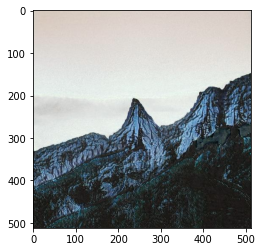

In [29]:
create_video(images)